## 1. Setup

In [1]:
import sys
sys.path.append('../..')

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import re
import shutil
import warnings

from keras import Model
from neural_networks.seg_reg_net import SegRegNet
from utils.data.data_generator import DataGenerator
from pprint import pprint

Using TensorFlow backend.


In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

warnings.filterwarnings('ignore')

## 2. Experiment parameters

In [4]:
DATASET_NAME = 'shanghai_tech/part_b'
DATASET_PATH = f'../../datasets/{DATASET_NAME}'
IMG_DIM = None
D_MAP_MULT_FACT = None
GT_SEG_THR = 123456789
PRED_SEG_THR = 1e-3

fontsize = 20
if DATASET_NAME.lower() == 'vgg_cells':
    # misc
    IMG_DIM = (256, 256, 3)
    D_MAP_MULT_FACT = 100.
    GT_SEG_THR = 8e-4
    
    # plots
    figsize=(30, 6)
    fraction = 0.0468
    pad = 0.015
    
    # checkpoints
    SEG_REG_NET_CHECKPOINT_NAME = f'../5_seg_reg_net/vgg_cells/n_64_sigma_5_randseed_644_loss_logcosh_patch_4_128x128'\
                                  f'/checkpoints/best_model.hdf5'

elif DATASET_NAME.lower() == 'carpk':
    # misc
    IMG_DIM = (720, 1280, 3)
    D_MAP_MULT_FACT = 2000.
    GT_SEG_THR = 1.5e-4
    
    # plots
    figsize=(30, 10)
    fraction = 0.027
    pad = 0.015
    
    # checkpoints
    SEG_REG_NET_CHECKPOINT_NAME = f'../5_seg_reg_net/carpk/sigma_10_loss_logcosh_full_img_epochs_3_lr_1e-4'\
                                  f'/checkpoints/model.02-0.010.hdf5'
    
elif DATASET_NAME.lower() == 'shanghai_tech/part_b':
    # misc
    IMG_DIM = (768, 1024, 3)
    D_MAP_MULT_FACT = 2000.
    GT_SEG_THR = 2e-4
    
    # plots
    figsize=(30, 10)
    fraction = 0.0355
    pad = 0.015
    
    # checkpoints
    SEG_REG_NET_CHECKPOINT_NAME = f'../5_seg_reg_net/shanghai_tech/part_b'\
                                  f'/sigma_10_loss_logcosh_patch_16_256x256_epochs_50_lr_1e-4'\
                                  f'/checkpoints/model.18-0.102.hdf5'

In [5]:
params = {
    'dim': IMG_DIM,
    'batch_size': 1,
    'patches_per_image': 1,
    'density_map_multiplication_factor': D_MAP_MULT_FACT,
    'shuffle': False,
    'output_mode': 'seg_reg',
    'gt_seg_thr': GT_SEG_THR
}

## 3. Predict and save results

In [6]:
gt_counts = []
seg_reg_net_pred_counts = []
seg_reg_net_pred_seg_density_counts = []

# data splits
test_generator = DataGenerator(DATASET_PATH, 'test', **params)

# clean old dir for qualitative results
results_path = f'2_seg_reg_net/{DATASET_NAME}/'
shutil.rmtree(results_path, ignore_errors=True)
os.makedirs(results_path)

# predict and save
seg_reg_net = SegRegNet(pretrained_weights=SEG_REG_NET_CHECKPOINT_NAME)

for data_generator, split_name in zip([test_generator],
                                      ['test']):
    # prepare dirs for qualitative results
    results_path_png_gt_asc = f'{results_path}/{split_name}/png_gt_asc'
    os.makedirs(results_path_png_gt_asc)

    for idx in range(data_generator.__len__()):
        # input image & gt seg and density map, batch_size=1
        input_img, gt = data_generator.__getitem__(idx)
        gt_seg_map, gt_density_map = gt
        gt_density_map /= D_MAP_MULT_FACT
        
        # predicted seg and density map
        seg_reg_net_pred = (seg_reg_net.predict(input_img))
        seg_reg_net_pred_seg_map, seg_reg_net_pred_density_map = seg_reg_net_pred
        seg_reg_net_pred_density_map /= D_MAP_MULT_FACT
        
        seg_reg_net_pred_seg_density_map = (seg_reg_net_pred_seg_map > PRED_SEG_THR)\
                                            *\
                                            seg_reg_net_pred_density_map
        
        # gt & pred counts
        gt_count = int(np.round(gt_density_map.sum()))
        seg_reg_net_pred_count = seg_reg_net_pred_density_map.sum()
        seg_reg_net_pred_seg_density_count = seg_reg_net_pred_seg_density_map.sum()
        seg_reg_net_pred_gt_diff = seg_reg_net_pred_count - gt_count
        

        gt_counts.append(gt_count)
        seg_reg_net_pred_counts.append(seg_reg_net_pred_count)
        seg_reg_net_pred_seg_density_counts.append(seg_reg_net_pred_seg_density_count)

        error_type = 'match'
        if seg_reg_net_pred_count < gt_count:
            error_type = 'underestimate'
        elif seg_reg_net_pred_count > gt_count:
            error_type = 'overestimate'

        img_name_png = data_generator.img_names[data_generator.indexes[idx]]
        img_name = img_name_png.split('.')[0]
        img_name_gt_asc = f'gt_{gt_count:3}_pred_{seg_reg_net_pred_count:6.2f}_diff_gt_pred_'\
                          f'{seg_reg_net_pred_gt_diff:.2f}'\
                          f'_{img_name}'.replace(' ', '0')

        # plots
        vmin = min(gt_density_map.min(), seg_reg_net_pred_density_map.min())
        vmax = max(gt_density_map.max(), seg_reg_net_pred_density_map.max())

        fig = plt.figure(figsize=figsize)
        num_subplots = 6
        
        plt.subplot(1, num_subplots, 1)
        plt.title('Input Image\n\n', fontsize=fontsize)
        plt.imshow(input_img[0])
        plt.colorbar(fraction=fraction, pad=pad)
        plt.axis('off')
        
        plt.subplot(1, num_subplots, 2)
        plt.title(f'Ground Truth\n[Segmentation Map]\n', fontsize=fontsize)
        plt.imshow(gt_seg_map.squeeze(), cmap='gray', vmin=0, vmax=1)
        plt.colorbar(fraction=fraction, pad=pad)
        plt.axis('off')
        
        plt.subplot(1, num_subplots, 3)
        plt.title(f'Prediction\n[Segmentation Map]\n', fontsize=fontsize)
        plt.imshow(seg_reg_net_pred_seg_map.squeeze(), cmap='gray', vmin=0, vmax=1)
        plt.colorbar(fraction=fraction, pad=pad)
        plt.axis('off')

        plt.subplot(1, num_subplots, 4)
        plt.title(f'Ground Truth\n[Density Map]\n{gt_count}', fontsize=fontsize)
        plt.imshow(gt_density_map.squeeze(), cmap='jet', vmin=vmin, vmax=vmax)
        plt.colorbar(fraction=fraction, pad=pad)
        plt.axis('off')
        
        plt.subplot(1, num_subplots, 5)
        plt.title(f'Prediction\n[Density Map]\n{seg_reg_net_pred_count:.2f}', fontsize=fontsize)
        plt.imshow(seg_reg_net_pred_density_map.squeeze(), cmap='jet', vmin=vmin, vmax=vmax)
        plt.colorbar(fraction=fraction, pad=pad)
        plt.axis('off')
        
        plt.subplot(1, num_subplots, 6)
        plt.title(f'Prediction\n[Seg & Density Map]\n{seg_reg_net_pred_seg_density_count:.2f}', fontsize=fontsize)
        plt.imshow(seg_reg_net_pred_seg_density_map.squeeze(), cmap='jet', vmin=vmin, vmax=vmax)
        plt.colorbar(fraction=fraction, pad=pad)
        plt.axis('off')
        
        plt.savefig(f'{results_path_png_gt_asc}/{img_name_gt_asc}.png')
        plt.clf()
        plt.close()

## 4. Plot GT vs Prediction

In [ ]:
print(gt_counts)
print(seg_reg_net_pred_counts)
print(seg_reg_net_pred_seg_density_counts)

In [8]:
def mae(gt, pred):
    gt = np.asarray(gt)
    pred = np.asarray(pred)
    return np.mean(np.abs(gt - pred))

print(f'SegRegNet (Density) MAE: {mae(gt_counts, seg_reg_net_pred_counts):.3f}')
print(f'SegRegNet (Seg & Density) MAE: {mae(gt_counts, seg_reg_net_pred_seg_density_counts):.3f}')

SegRegNet (Density) MAE: 18.939
SegRegNet (Seg & Density) MAE: 18.826


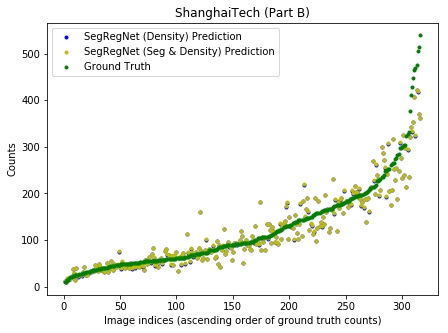

In [9]:
x = 1 + np.arange(len(gt_counts))
indices = np.argsort(gt_counts)
plt.figure(figsize=(7, 5))
if DATASET_NAME.lower() == 'vgg_cells':
    plt.title('VGG Cells')
elif DATASET_NAME.lower() == 'carpk':
    plt.title('CARPK')
elif DATASET_NAME.lower() == 'shanghai_tech/part_b':
    plt.title('ShanghaiTech (Part B)')
    
plt.plot(x, np.asarray(seg_reg_net_pred_counts)[indices], 'b.', label='SegRegNet (Density) Prediction')
plt.plot(x, np.asarray(seg_reg_net_pred_seg_density_counts)[indices], 'y.', label='SegRegNet (Seg & Density) Prediction')
plt.plot(x, np.asarray(gt_counts)[indices], 'g.', label='Ground Truth')
plt.ylabel('Counts')
plt.xlabel('Image indices (ascending order of ground truth counts)')
plt.legend()
plt.savefig(f'{results_path}/analysis.png')
plt.show()